In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader 
from torch.autograd import Variable
from tqdm import trange
from sklearn.metrics import mean_squared_error as mse
from hydroeval import evaluator, nse, kge, kgeprime
import time
import shap


torch.manual_seed(0)

if torch.cuda.is_available():  
    device = "cuda:0" 
else:  
    device = "cpu"  

In [3]:
X = pd.read_csv("../data/processed/gw_stage2.CSV",
                    parse_dates=['Datetime'],
                    index_col=['Datetime'])
print('Initial GW-SW Input Size: ',X.shape)
y = pd.read_csv("../data/processed/spring.CSV",
                    parse_dates=['datetime'],
                    index_col=['datetime'])
key_value = np.loadtxt("../data/processed/NameKey2.CSV", dtype= "str", delimiter=",", skiprows=1)
stationNames = { k:v for k,v in key_value }
#print(stationNames)
tooClose=['8','9','10','12','13','14','25', '44', '61', '72']
for i in tooClose:
    print(stationNames[i])

#Drop values exctremely close to the Sprin head
X.drop(X.columns[[8,9,10,12,13, 14, 25,44,61,72]], axis=1, inplace=True)
print("Excluded GW-SW Input Shape: ", X.shape)
X.rename(columns = stationNames, inplace = True)

GW_SW=X.copy()

GW=X.iloc[:,:23]

SW=X.iloc[:,23:]

MET=pd.read_csv("../data/processed/DailyMet.CSV",
                parse_dates=['Datetime'],
                index_col=['Datetime'])




#Add Y columns as a separate column
y['timestamp']=y.index
y['timestamp']=pd.to_datetime(y['timestamp']).dt.tz_convert(None)
#=pd.to_datetime(['timestamp'], format='%Y-%m-%d %H:%M:%S')
y=y.rename(columns={'Gage_Height':'Wakulla', 'timestamp':'Datetime'})
y=y.set_index('Datetime')


#DF of Met data with Wakulla
met_df=MET.merge(y,how='inner', right_index=True, left_index=True)
met_names=met_df.columns[:-1]

#DF of GW DATA with Wakulla
gw_df=GW.merge(y,how='inner', right_index=True, left_index=True)
gw_names=gw_df.columns[:-1]

#DF of SW dATA with Wakulla
sw_df=SW.merge(y,how='inner', right_index=True, left_index=True)
sw_names=sw_df.columns[:-1]

#DF of MET + GW + Wakulla
GW_MET=pd.concat([GW, MET], axis =1)
met_gw_df=GW_MET.merge(y,how='inner', right_index=True, left_index=True)
met_gw_names=met_gw_df.columns[:-1]

#Df of MET + SW + Wakulla
SW_MET=pd.concat([SW, MET], axis =1)
met_sw_df=SW_MET.merge(y,how='inner', right_index=True, left_index=True)
met_sw_names=met_sw_df.columns[:-1]

#dF OF GW + SW + Wakula
gw_sw_df=GW_SW.merge(y,how='inner', right_index=True, left_index=True)
gw_sw_names=gw_sw_df.columns[:-1]

#DF of MET + GW + SW + Wakulla
GW_SW_MET=pd.concat([GW_SW, MET], axis=1)
gw_sw_met_df=GW_SW_MET.merge(y, how='inner', right_index=True, left_index=True)
gw_sw_met_names=gw_sw_met_df.columns[:-1]

del(X,y,MET, GW,SW, GW_SW)

inputs_list=[met_df, gw_df, sw_df, met_gw_df, met_sw_df, gw_sw_df, gw_sw_met_df]
inputs_list_str=["MET", "GW","SW", "MET+ GW", "MET + SW", "GW + SW", "MET + GW + SW"]
inputnames_list=[met_names, gw_names, sw_names, met_gw_names, met_sw_names, gw_sw_names, gw_sw_met_names]

Initial GW-SW Input Size:  (1101, 74)
NWFWMD-NITRATE 1
NWFWMD-NITRATE 2/S790
NWFWMD-NITRATE 4/S782
NWFWMD-NITRATE 6/S797
WAKULLA CORRECTIONAL INSTITUTE 1/S779
WAKULLA CONDUIT WELL@WEST OF HWY 61
NWFWMD GW-12F (RIVERSPRINGS MS)/S820
St  Marks River @ San Marcos de Apalachee S P 
WAKULLA RIVER AT BOAT TRAM
INDIAN SPRING RUN AT SR61
Excluded GW-SW Input Shape:  (1101, 64)


In [3]:
def scale_and_split(df):
    train, test = train_test_split(df, test_size=0.30, shuffle = False)
    train, val = train_test_split(val, test_size=0.2, shuffle = False)
    
    #Use train set as the sclaer to prevent data leakage
    X_scaler = StandardScaler().fit(train.iloc[:,:-1])
    train_Xscaled = X_scaler.transform(train.iloc[:,:-1])
    y_scaler= MinMaxScaler().fit(train.iloc[:,-1:])
    train_yscaled= y_scaler.transform(train.iloc[:,-1:])
    
    train_scaled = pd.DataFrame(np.append(train_Xscaled, train_yscaled,1), columns = df.columns[:])
 
    
    val_Xscaled = X_scaler.transform(val.iloc[:,:-1])
    val_yscaled= y_scaler.transform(val.iloc[:,-1:])
    val_scaled = pd.DataFrame(np.append(val_Xscaled, val_yscaled,1), columns = df.columns[:])
    
    test_Xscaled = X_scaler.transform(test.iloc[:,:-1])
    test_yscaled= y_scaler.transform(test.iloc[:,-1:])
    test_scaled = pd.DataFrame(np.append(test_Xscaled, test_yscaled,1), columns = df.columns[:])
    
    full_scaled_X=X_scaler.transform(df.iloc[:,:-1])
    full_scaled_y=y_scaler.transform(df.iloc[:,-1:])
    
    #return val_scaled,
    
    return train_scaled,  test_scaled, X_scaler, y_scaler, full_scaled_X, full_scaled_y

#Old one

def prepare_inputs_outputs(train, test, seq_len, inputs, output):   
    X_train, y_train = train[:len(train)-seq_len][inputs], train[[output]]
    X_val, y_val = val[:len(val)-seq_len][inputs], val[[output]]
    X_test, y_test = test[:len(test)-seq_len][inputs], test[[output]]
    #test[:len(test)-seq_len][inputs], test[[output]]
    return X_train, y_train,  X_test, y_test, X_val, y_val

'''
## Try New One
def prepare_inputs_outputs(train, val, test, seq_len, inputs, output):   
    X_train, y_train = train[inputs], train[output][seq_len-1:]
    X_val, y_val = val[:len(val)-seq_len][inputs], val[[output]]
    X_test, y_test = test[:len(test)-seq_len][inputs], test[[output]]
    return X_train, y_train, X_val, y_val, X_test, y_test
'''
###Theory here is that we take [seq_len] numbered away from trainX and pass it to Val_X 
#and same with val to Test set
#May not be necessary

'\n## Try New One\ndef prepare_inputs_outputs(train, val, test, seq_len, inputs, output):   \n    X_train, y_train = train[inputs], train[output][seq_len-1:]\n    X_val, y_val = val[:len(val)-seq_len][inputs], val[[output]]\n    X_test, y_test = test[:len(test)-seq_len][inputs], test[[output]]\n    return X_train, y_train, X_val, y_val, X_test, y_test\n'

In [4]:
class TimeSeries(Dataset):
    def __init__(self, X, y, seq_len):
        self.X = torch.tensor(np.array(X) ,dtype=torch.float32)
        self.y = torch.tensor(np.array(y) ,dtype=torch.float32)
        #self.column_input = column_input
        #self.column_output = column_output
        self.seq_len = seq_len
        
    #Gets the input sequence [X : X +seq_len], adn the corresponding, singular y+seq_len    
    def __getitem__(self,idx):
        return self.X[idx:idx+self.seq_len-1], self.y[idx+self.seq_len-1]

    def __len__(self):
        return len(self.X) - (self.seq_len-1)
    
    
def get_dataloader(X, y,seq_len, batch_size):
    return DataLoader(TimeSeries(X, y, seq_len),  batch_size, shuffle=False, drop_last = True)

In [9]:
class LSTM_FC_Drop_FC(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length, drop_rate):
        super().__init__()
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length
        self.drop_rate = drop_rate
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc =  nn.Linear(hidden_size, hidden_size)
        self.dropout=nn.Dropout(drop_rate)
        self.fc1 =  nn.Linear(hidden_size, 1) #fully connected 1
    
    def forward(self,x):   
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        #hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.fc(hn)#first Dense
        out=self.dropout(out)
        out = self.fc1(out)#first Dense
        return out

In [6]:
def train_model(model, train_loader,test_loader, loss_function, optimizer, epochs):


    train_val_history = {'train': [],
                        'val': []}
    for i in trange(epochs):
        for j, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            #print(inputs.shape)
            y_pred = model(inputs)
            #print(y_pred.shape)
            labels_3D=labels.reshape(1,labels.shape[0],labels.shape[1])
           
            single_loss = torch.sqrt(loss_function(y_pred, labels_3D)) #RMSE

            single_loss.backward()

            optimizer.step()

        train_val_history['train'].append(single_loss.item())
        #print("Training data : " + f'epoch: {i:3} loss: {single_loss.item():10.8f}')

        for j, data in enumerate(test_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            labels_3D=labels.reshape(1,labels.shape[0],labels.shape[1])
            y_pred = model(inputs)

            single_loss = torch.sqrt(loss_function(y_pred, labels_3D))

        train_val_history['val'].append(single_loss.item())
        #if i % 20 == 0:
            #print("Training data : epoch: ", i, " loss: ", train_val_history['train'][-1])
            #print("Validation data :  epoch: ", i, " loss: ", train_val_history['val'][-1])

    #print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
    return model, train_val_history

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.53it/s]

Data Input: MET


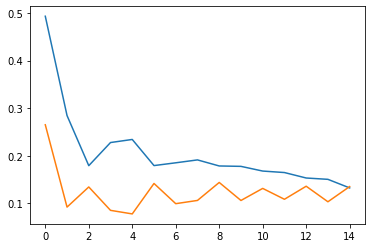

train  MSE:  0.09999130567680081
Test NSE: [-1.69808788]
Test KGE: 0.5910790789608016
test  MSE:  0.18530950427195272
Full NSE: [0.3272465]
Full KGE: 0.5238965478898112
Full  MSE:  0.14669618597505207


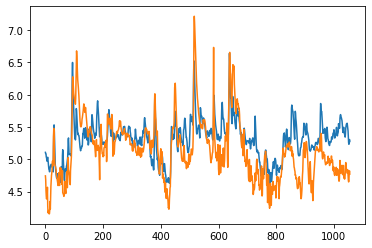

Done!


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.59it/s]

Data Input: GW


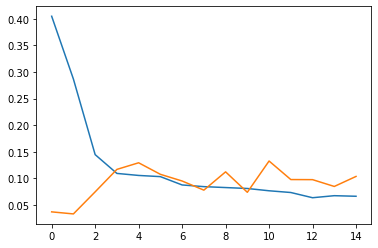

train  MSE:  0.03623251246602147
Test NSE: [-1.89737249]
Test KGE: 0.31708665057206264
test  MSE:  0.1989967277970813
Full NSE: [0.57860943]
Full KGE: 0.7633235022530189
Full  MSE:  0.09188564496708786


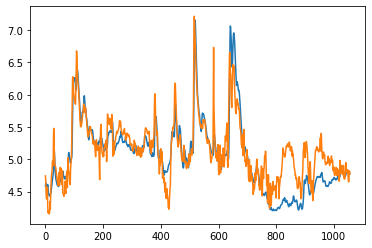

Done!


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.46it/s]

Data Input: SW


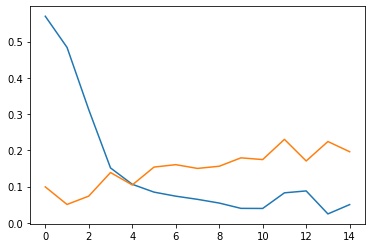

train  MSE:  0.02264451382554607
Test NSE: [-0.81590163]
Test KGE: 0.2483360682239526
test  MSE:  0.12471937397576968
Full NSE: [0.71048629]
Full KGE: 0.8699667212079405
Full  MSE:  0.06312944866453113


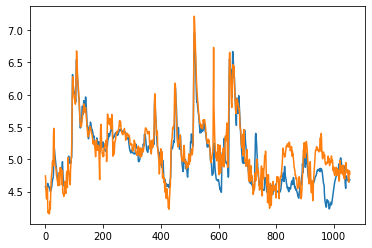

Done!


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.55it/s]

Data Input: MET+ GW


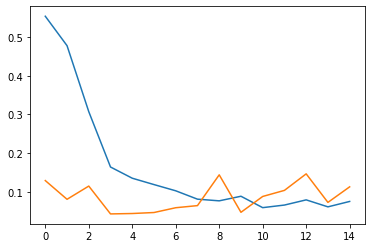

train  MSE:  0.023522519574879133
Test NSE: [-4.95829645]
Test KGE: -0.02703784343432858
test  MSE:  0.4092264641439691
Full NSE: [0.28199664]
Full KGE: 0.6570900962451429
Full  MSE:  0.15656307094627372


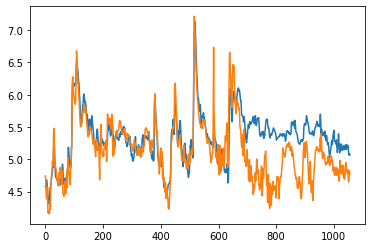

Done!


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.65it/s]

Data Input: MET + SW


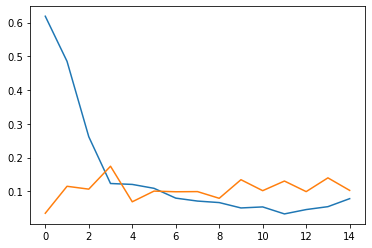

train  MSE:  0.021515134462981575
Test NSE: [0.18809137]
Test KGE: 0.5030332490127205
test  MSE:  0.055763337466972006
Full NSE: [0.6583197]
Full KGE: 0.793707913620291
Full  MSE:  0.07450455093923099


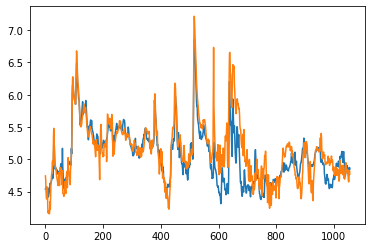

Done!


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.64it/s]

Data Input: GW + SW


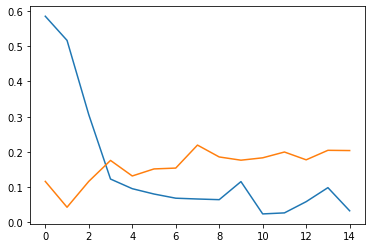

train  MSE:  0.016996426691486367
Test NSE: [-8.78480262]
Test KGE: 0.4820816274586982
test  MSE:  0.6720377564211211
Full NSE: [-0.04870545]
Full KGE: 0.4869363182699832
Full  MSE:  0.22867378583841827


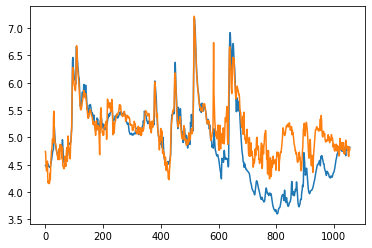

Done!


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.63it/s]

Data Input: MET + GW + SW


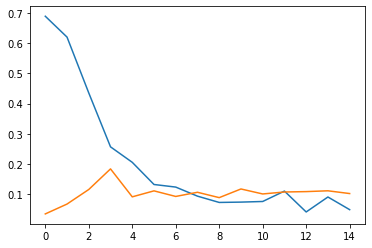

train  MSE:  0.018874183076573497
Test NSE: [-0.45631218]
Test KGE: 0.48077101561430713
test  MSE:  0.10002212685417017
Full NSE: [0.66970462]
Full KGE: 0.8349390601576847
Full  MSE:  0.07202202970580729


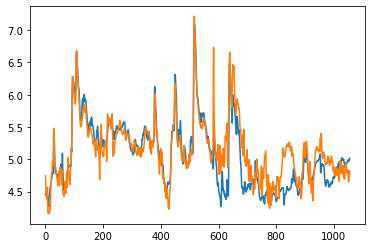

Done!


In [7]:
TEST_NSE=[]
FULL_NSE=[]
TEST_KGE=[]
FULL_KGE=[]
FULL_MSE=[]
TEST_MSE=[]
for i in range(len(inputs_list)):

    inputs=list(inputnames_list[i])
    parameters = {'inputs':inputs,
              'input_size': len(inputs),
              'outputs':['Wakulla'],
              'seq_len': 40,
              'hidden_size': 100, #Same as batch5
              'batch_size_train':64,
              'batch_size_val':8,
              'batch_size_test':32,
              'lr':0.0005,
              'epochs':15,
              'num_layers':1   #Number of LSTM layers
             }

    train, test, X_scaler, y_scaler, full_scaled_X, full_scaled_y = scale_and_split(inputs_list[i]) 




    X_train, y_train, X_test, y_test = prepare_inputs_outputs(train, test, 
                                                                        parameters['seq_len'],
                                                                        parameters['inputs'],
                                                                        parameters['outputs'][0])
    
    model=LSTM_FC_FC(parameters['input_size'], parameters['hidden_size'], 
                     parameters['num_layers'],parameters['seq_len'])    
    
    train_loader = get_dataloader(X_train, y_train, parameters['seq_len'],parameters['batch_size_train'])
    #al_loader = get_dataloader(X_val, y_val, parameters['seq_len'],parameters['batch_size_val'])
    test_loader = get_dataloader(X_test, y_test, parameters['seq_len'], parameters['batch_size_test'])
    full_loader=get_dataloader(full_scaled_X, full_scaled_y, parameters['seq_len'], parameters['batch_size_test'])                                           
    
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters['lr'])
    loss_function = nn.MSELoss()
    model, train_val_history = train_model(model, 
                                                train_loader, 
                                                test_loader,
                                                loss_function, 
                                                optimizer, 
                                                parameters['epochs'])
    
    #print(model)
    print("Data Input:", inputs_list_str[i])
    plt.plot(train_val_history['train'])
    plt.plot(train_val_history['val'])
    plt.show()
    plt.close()
    full_label=[]
    full_pred=[]

    train_label=[]
    train_pred=[]
    #al_label=[]
    #al_pred=[]
    test_label=[]
    test_pred=[]

    for j, data in enumerate(train_loader):
                inputs, labels = data[0].to(device), data[1].to(device)
                #optimizer.zero_grad()
                labels_3D=labels.reshape(1,labels.shape[0],labels.shape[1])
                y_pred = model(inputs)          
                train_pred.append(y_pred.squeeze().tolist())
                train_label.append(labels.squeeze().tolist())
    train_predictions_l = [item for sublist in train_pred for item in sublist]
    train_predictions=np.array(train_predictions_l).reshape(-1,1)

    train_real_y_l=[item for sublist in train_label for item in sublist]
    train_real_y=np.array(train_real_y_l).reshape(-1,1)

    train_predictions=y_scaler.inverse_transform(train_predictions)
    train_real_y=y_scaler.inverse_transform(train_real_y)
    print("train  MSE: ", mse(train_predictions, train_real_y))


    #or j, data in enumerate(val_loader):
     #          inputs, labels = data[0].to(device), data[1].to(device)
     #          #optimizer.zero_grad()
      #         labels_3D=labels.reshape(1,labels.shape[0],labels.shape[1])
       #        y_pred = model(inputs)            
        #       val_pred.append(y_pred.squeeze().tolist())
         #      val_label.append(labels.squeeze().tolist())


    #al_predictions_l = [item for sublist in val_pred for item in sublist]
    #al_predictions=np.array(val_predictions_l).reshape(-1,1)

   # val_real_y_l=[item for sublist in val_label for item in sublist]
   # val_real_y=np.array(val_real_y_l).reshape(-1,1)

    #val_predictions=y_scaler.inverse_transform(val_predictions)
    #val_real_y=y_scaler.inverse_transform(val_real_y)
    #print("val  MSE: ", mse(val_predictions, val_real_y))

    for j, data in enumerate(test_loader):
                inputs, labels = data[0].to(device), data[1].to(device)
                #optimizer.zero_grad()
                labels_3D=labels.reshape(1,labels.shape[0],labels.shape[1])
                y_pred = model(inputs)        
                test_pred.append(y_pred.squeeze().tolist())
                test_label.append(labels.squeeze().tolist())

    test_predictions_l = [item for sublist in test_pred for item in sublist]
    test_predictions=np.array(test_predictions_l).reshape(-1,1)

    test_real_y_l=[item for sublist in test_label for item in sublist]
    test_real_y=np.array(test_real_y_l).reshape(-1,1)

    test_predictions=y_scaler.inverse_transform(test_predictions)
    test_real_y=y_scaler.inverse_transform(test_real_y)
    
    test_nse=evaluator(nse, test_predictions, test_real_y)
    print("Test NSE:", test_nse)
    TEST_NSE.append(test_nse)
    
    test_kge=evaluator(kge, test_predictions, test_real_y)[0][0]
    print("Test KGE:", test_kge)
    TEST_KGE.append(test_kge)

    test_mse=mse(test_predictions, test_real_y)
    print("test  MSE: ", test_mse)
    TEST_MSE.append(test_mse)
    
    full_pred=[]
    full_label=[]
    for j, data in enumerate(full_loader):
                inputs, labels = data[0].to(device), data[1].to(device)
                #optimizer.zero_grad()
                labels_3D=labels.reshape(1,labels.shape[0],labels.shape[1])
                y_pred = model(inputs)
                full_pred.append(y_pred.squeeze().tolist())
                full_label.append(labels.squeeze().tolist())

    full_predictions_l = [item for sublist in full_pred for item in sublist]
    full_predictions=np.array(full_predictions_l).reshape(-1,1)

    full_real_y_l=[item for sublist in full_label for item in sublist]
    full_real_y=np.array(full_real_y_l).reshape(-1,1)

    full_predictions=y_scaler.inverse_transform(full_predictions)
    full_real_y=y_scaler.inverse_transform(full_real_y)

    full_nse=evaluator(nse, full_predictions, full_real_y)
    print("Full NSE:", full_nse)
    FULL_NSE.append(full_nse)
    
    full_kge=evaluator(kge, full_predictions, full_real_y)[0][0]
    print("Full KGE:", full_kge)
    FULL_KGE.append(full_kge)

    full_mse=mse(full_predictions, full_real_y)
    print("Full  MSE: ", full_mse)
    FULL_MSE.append(full_mse)
    

    plt.plot(full_predictions)
    plt.plot(full_real_y)
    plt.show()
    plt.close()
    print("Done!")

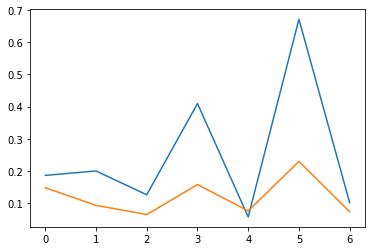

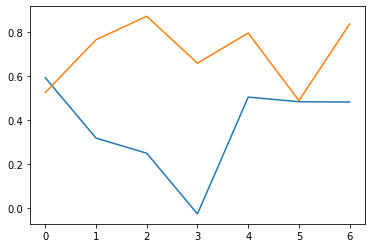

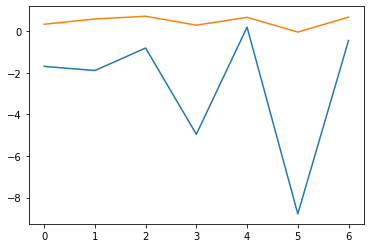

In [8]:
plt.plot(TEST_MSE)
plt.plot(FULL_MSE)
plt.show()
plt.close()
plt.plot(TEST_KGE)
plt.plot(FULL_KGE)
plt.show()
plt.close()
plt.plot(TEST_NSE)
plt.plot(FULL_NSE)
plt.show()
plt.close()

In [9]:
inputs_list_str


['MET', 'GW', 'SW', 'MET+ GW', 'MET + SW', 'GW + SW', 'MET + GW + SW']

In [197]:
A=torch.tensor(X_train.values)
A.shape

torch.Size([675, 69])

In [ ]:
from captum.attr import IntegratedGradients

ig = IntegratedGradients(model)
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor,target=1, return_convergence_delta=True)
attr = attr.detach().numpy()

In [196]:
st=time.time()

inputs, _ = next(iter(train_loader))
print(inputs.shape)
background=inputs[:60]
other=inputs[60:]
test_input, _= next(iter(test_loader))

explainer = shap.DeepExplainer(model, torch.tensor(X_train.values) )

shap_values=explainer.shap_values(other)

et=time.time()

print("elapsed time: ", et-st, " seconds")


torch.Size([64, 39, 69])


RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors

In [182]:
print(len(shap_values))
print(shap_values[0].shape)
a=np.array(shap_values[0])
((a > 0).sum() == a.size).astype(np.int)

64
(4, 39, 69)


0

In [183]:
shap_values

[array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0

In [170]:
X_train

AttributeError: 'DataFrame' object has no attribute 'type'